Visium v1 QC and normalization
==

In [1]:
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set logging and figure parameters
sc.settings.verbosity = 3
sc.set_figure_params(facecolor='white', figsize=(8, 8))

/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return m

Data loading
--
Replace the path to filtered_feature_bc_matrix.h5 (output from SpaceRanger) with 
desired sample path.

In [194]:
spaceranger_file_path = Path("/home/vlad/Projects/SpTx/data/visium_crc_cms/SN124/SN124_A938797_Rep2")
sample_id = spaceranger_file_path.stem 
dst = Path("/home/vlad/Projects/SpTx/visium/")  # where to save the normalized data

In [195]:
adata = sq.read.visium(spaceranger_file_path)

# Make gene names unique and store raw counts
adata.var_names_make_unique()
# Store the raw count matrix in the 'counts' layer for safe keeping
adata.layers["counts"] = adata.X.copy()
print(f"Initial data shape: {adata.shape}")

reading /home/vlad/Projects/SpTx/data/visium_crc_cms/SN124/SN124_A938797_Rep2/filtered_feature_bc_matrix.h5
 (0:00:00)
Initial data shape: (1691, 36601)


/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/vlad/.pyenv/versions/3.12.7/envs/sptx/lib/python3.12/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


QC
--

In [196]:
# --- QC Metrics Calculation ---
# 1. Identify mitochondrial genes (used for calculating mitochondrial percentage)
# for mouse use "mt-".
adata.var['mt'] = adata.var_names.str.startswith('MT-')

# 2. Calculate QC metrics for spots (cells) and genes
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

# Important QC metrics are now stored in adata.obs:
# - total_counts: Total UMI counts per spot (library size).
# - n_genes_by_counts: Number of unique genes detected in the spot.
# - pct_counts_mt: Percentage of counts belonging to mitochondrial genes.

print("\nQC table head:\n", 
      adata.obs[['total_counts', 'n_genes_by_counts', 'pct_counts_mt']].head())


QC table head:
                     total_counts  n_genes_by_counts  pct_counts_mt
AAACAATCTACTAGCA-1       29697.0               7352       1.205509
AAACAGAGCGACTCCT-1       33122.0               7310       2.095284
AAACGAAGAACATACC-1       35719.0               7503       1.942944
AAACGAGACGGTTGAT-1       30983.0               7585       2.055966
AAACTGCTGGCTCCAA-1       13279.0               4832       5.813691


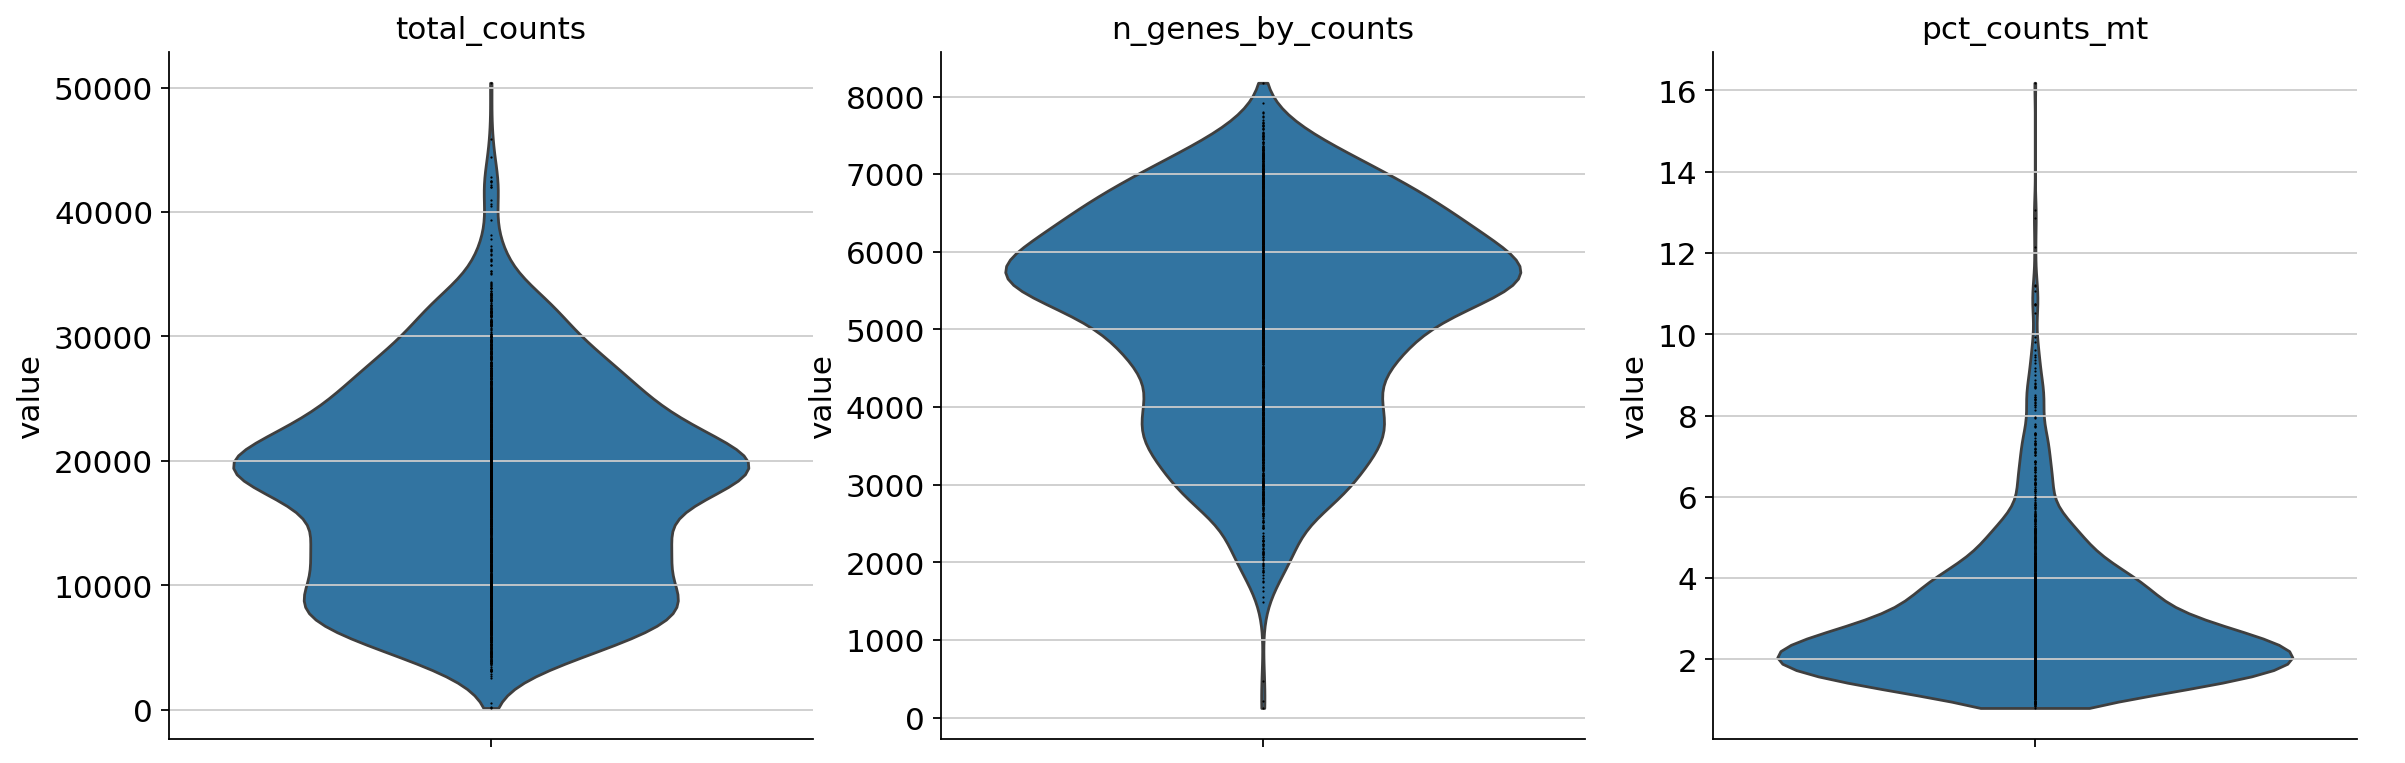

<Figure size 640x640 with 0 Axes>

In [197]:
# --- QC Visualization (using squidpy.pl and corrected scanpy.pl) ---

# Corrected Violin plots: Remove the 'title' argument when using multi_panel=True
# We rely on the automatic labeling of the features on the x-axis.
sc.pl.violin(
    adata,
    ['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    multi_panel=True,
    jitter=False,
    # REMOVED: title='QC Metrics Distributions'
)

# You can add a figure title manually using matplotlib after the fact
plt.suptitle('QC Metrics Distributions Across Spots', y=1.02)
plt.show()

If the diagnosis below removes too many spots, apply milder thresholds:

Recommended Milder Thresholds for Visium:
- genes detected: lower min_genes from 200 to 50 or 100.
- total UMI counts: lower min_counts from 500 to 100 or 200.
- mitochondrial %: increase the threshold from 30% to 40% or 50% (especially if the tissue is known to have regions with naturally high mitochondrial content).

In [198]:
# --- QC Diagnostics: Check Spot Loss ---
initial_spots = adata.n_obs

# Diagnostic Filter 1: Min Counts and Min Genes
adata_temp = adata.copy()
sc.pp.filter_cells(adata_temp, min_counts=500)
sc.pp.filter_cells(adata_temp, min_genes=200)
spots_after_counts_genes = adata_temp.n_obs
print(f"Spots removed by min counts/genes: {initial_spots - spots_after_counts_genes} ({100 * (initial_spots - spots_after_counts_genes) / initial_spots:.2f}%)")

# Diagnostic Filter 2: Mitochondrial Percentage
adata_temp = adata_temp[adata_temp.obs['pct_counts_mt'] < 30, :].copy()
final_spots_temp = adata_temp.n_obs
print(f"Spots remaining after all filters (tentative): {final_spots_temp}")

# IMPORTANT: If 'final_spots_temp' is 0 or very small (e.g., < 100), you must loosen the thresholds.
del adata_temp # Clean up temporary object

filtered out 2 cells that have less than 500 counts
Spots removed by min counts/genes: 2 (0.12%)
Spots remaining after all filters (tentative): 1689


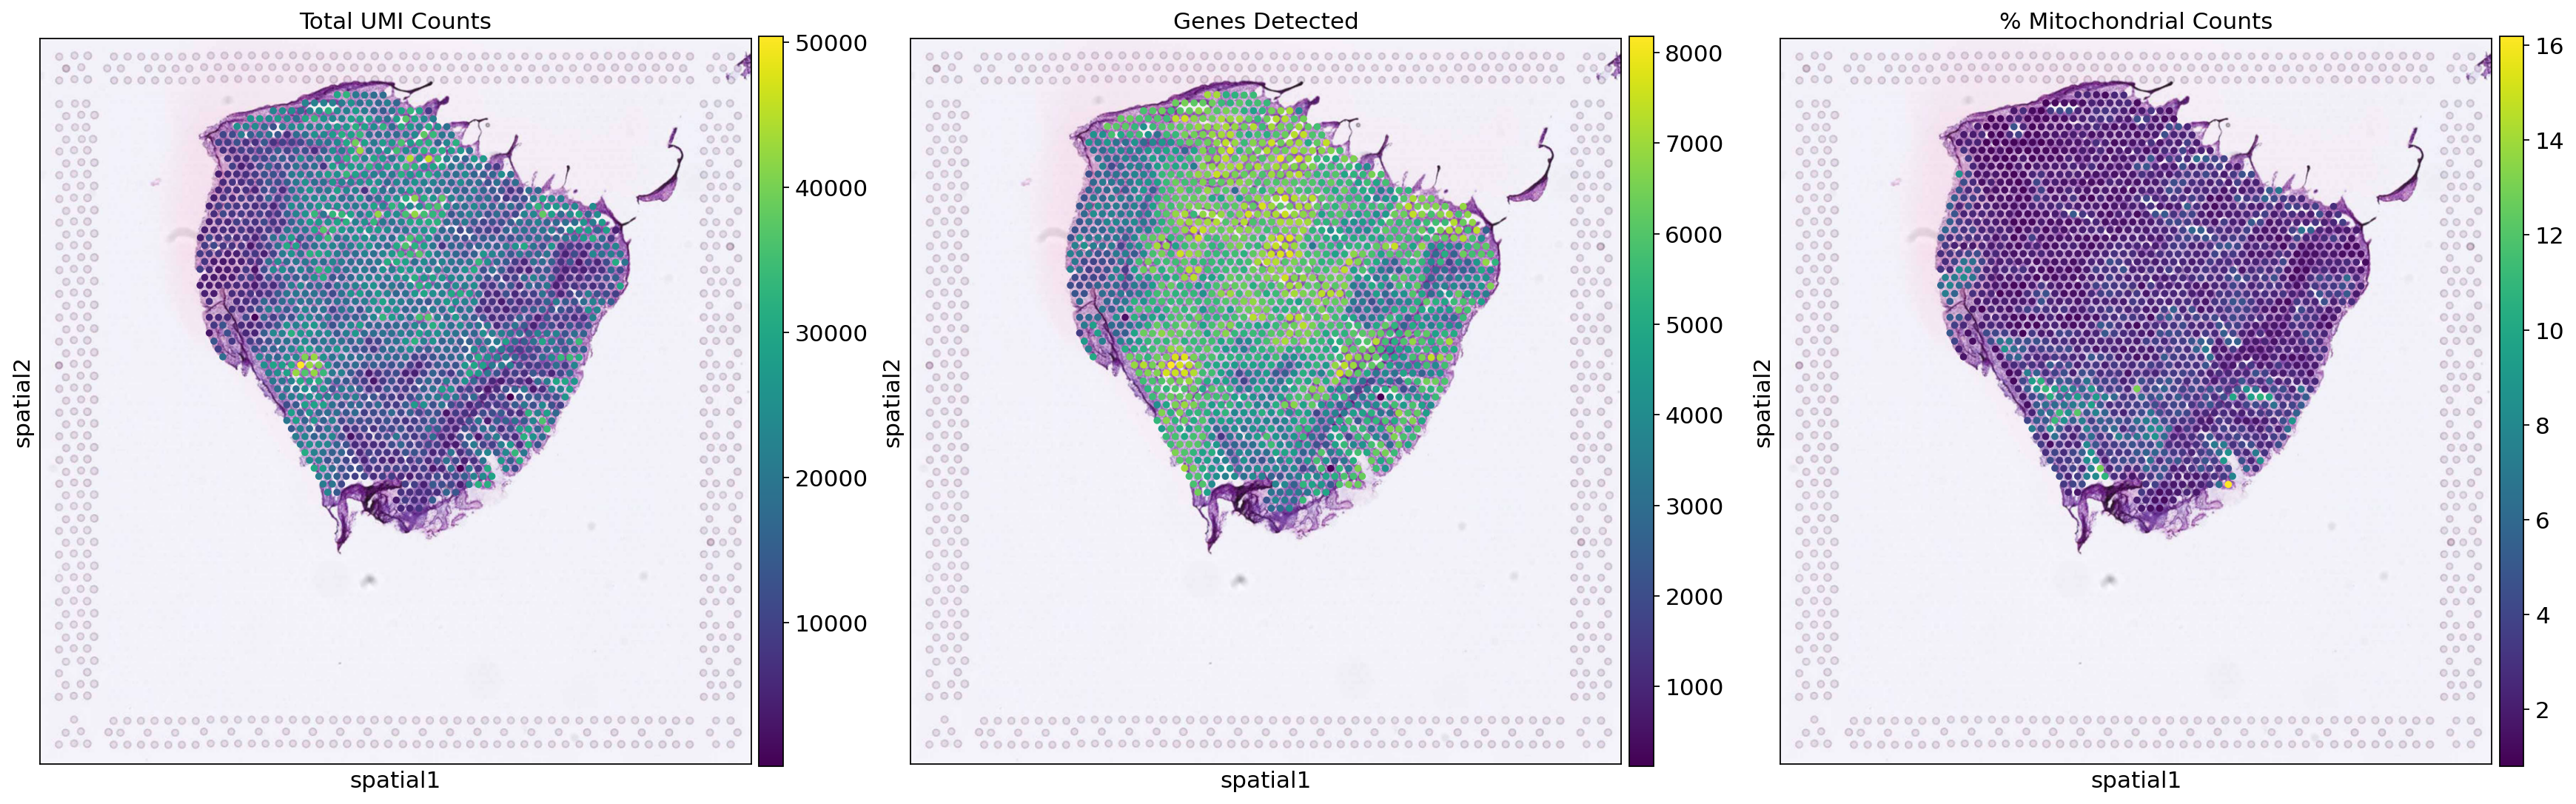

In [199]:

# Visualize QC metrics in spatial context (Squidpy's primary spatial plotter)
# This plotter handles multiple colors/titles correctly.
sq.pl.spatial_scatter(
    adata,
    color=['total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    ncols=3,
    size=1.2,
    title=['Total UMI Counts', 'Genes Detected', '% Mitochondrial Counts']
)

Normalization
--

In [200]:
# --- Normalization (using scanpy.pp) ---

# Total-count normalization to 10,000 (CP10K)
sc.pp.normalize_total(adata, target_sum=1e4)

# --- Log-Transformation (using scanpy.pp) ---

# Logarithmize the data (log(1+X)) to stabilize variance.
sc.pp.log1p(adata)

print(f"Final data shape: {adata.shape}")

normalizing counts per cell
    finished (0:00:00)
Final data shape: (1691, 36601)


Save
--
Save the relevant data.

In [201]:
adata.obs.head()

,in_tissue,array_row,array_col,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACAATCTACTAGCA-1,1,3,43,7352,29697.0,358.0,1.205509
AAACAGAGCGACTCCT-1,1,14,94,7310,33122.0,694.0,2.095284
AAACGAAGAACATACC-1,1,6,64,7503,35719.0,694.0,1.942944
AAACGAGACGGTTGAT-1,1,35,79,7585,30983.0,637.0,2.055966
AAACTGCTGGCTCCAA-1,1,45,67,4832,13279.0,772.0,5.813691


In [202]:
expression_df = pd.DataFrame(
    adata.X.toarray(),
    index=adata.obs_names,
    columns=adata.var_names
)

In [203]:
expression_df.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACAATCTACTAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACAGAGCGACTCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACGAAGAACATACC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246831,0.0
AAACGAGACGGTTGAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
AAACTGCTGGCTCCAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [204]:
expression_df.to_feather( 
    dst / sample_id / "expression_normalized.feather", 
    compression_level=9
)

In [205]:
genes = expression_df.apply(lambda row: row[row > 0].index.tolist(), axis=1)

In [206]:
genes

AAACAATCTACTAGCA-1    [SAMD11, NOC2L, KLHL17, HES4, ISG15, AGRN, C1o...
AAACAGAGCGACTCCT-1    [LINC01409, LINC01128, NOC2L, HES4, C1orf159, ...
AAACGAAGAACATACC-1    [LINC01128, NOC2L, PLEKHN1, HES4, ISG15, AGRN,...
AAACGAGACGGTTGAT-1    [LINC01128, NOC2L, HES4, AGRN, C1orf159, AL390...
AAACTGCTGGCTCCAA-1    [NOC2L, PLEKHN1, ISG15, AGRN, TNFRSF4, SDF4, B...
                                            ...                        
TTGTGGCCCTGACAGT-1    [LINC01409, SAMD11, NOC2L, KLHL17, HES4, ISG15...
TTGTTAGCAAATTCGA-1    [SAMD11, NOC2L, AL645608.7, HES4, ISG15, C1orf...
TTGTTCAGTGTGCTAC-1    [HES4, ISG15, AGRN, TNFRSF18, SDF4, B3GALT6, I...
TTGTTGTGTGTCAAGA-1    [SAMD11, NOC2L, ISG15, C1orf159, TNFRSF18, SDF...
TTGTTTGTGTAAATTC-1    [SAMD11, NOC2L, KLHL17, HES4, ISG15, AL390719....
Length: 1691, dtype: object

In [207]:
expression_df.iloc[0][genes[0]]

/tmp/ipykernel_39885/891000676.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expression_df.iloc[0][genes[0]]


SAMD11    0.514899
NOC2L     0.514899
KLHL17    0.290230
HES4      0.290230
ISG15     0.853111
            ...   
MT-ND3    2.376328
MT-ND4    2.881259
MT-ND5    0.514899
MT-ND6    0.290230
MT-CYB    2.168469
Name: AAACAATCTACTAGCA-1, Length: 7352, dtype: float32